In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

In [0]:
os.chdir('drive/My Drive/Dataset')

In [0]:
def unpickle(file):
  import pickle
  with open(file, 'rb') as fo:
      dict = pickle.load(fo, encoding='bytes')
  return dict

In [0]:
def Load_Data():
  
  train_set_X = []
  train_set_Y = []
  test_set_X = []
  test_set_Y = []
  
  for i in range(1,6):
    filename = 'data_batch_'+str(i)
    dict = unpickle(filename)
    X = dict[b'data']
    Y = dict[b'labels']
    train_set_X.extend(X)
    train_set_Y.extend(Y)
    
  train_set_X = np.array(train_set_X)
  train_set_Y = np.array(train_set_Y)
  
  
  filename = 'test_batch'
  dict = unpickle(filename)
  test_set_X = np.array(dict[b'data'])
  test_set_Y = np.array(dict[b'labels'])
  
  
  filename = 'batches.meta'
  dict = unpickle(filename)
  classes = np.array(dict[b'label_names'])

  #print(train_set_X.shape,train_set_Y.shape,test_set_X.shape,test_set_Y.shape,classes.shape)
  return train_set_X,train_set_Y,test_set_X,test_set_Y,classes

In [0]:
def Reshape_And_Normalize(train_set_X,train_set_Y,test_set_X,test_set_Y):
  
  m_train = train_set_X.shape[0]
  m_test = test_set_X.shape[0]
  U_train = np.sum(train_set_X,axis=1,keepdims=True)/m_train
  U_test = np.sum(test_set_X,axis=1,keepdims=True)/m_test
  
  train_set_X = train_set_X - U_train
  test_set_X = test_set_X - U_test
  sigma_train = np.sqrt(np.sum(np.square(train_set_X),axis=1,keepdims=True)/m_train)
  sigma_test = np.sqrt(np.sum(np.square(test_set_X),axis=1,keepdims=True)/m_test)
  
  train_set_X = train_set_X/sigma_train
  test_set_X = test_set_X/sigma_test
  
  train_set_X = train_set_X.reshape(train_set_X.shape[0],3,32,32)
  train_set_X = np.moveaxis(train_set_X,1,3)
  train_set_Y = train_set_Y.reshape(1,train_set_Y.shape[0])
  test_set_X = test_set_X.reshape(test_set_X.shape[0],3,32,32)
  test_set_X = np.moveaxis(test_set_X,1,3)
  test_set_Y = test_set_Y.reshape(1,test_set_Y.shape[0])
  
  train_set_X = train_set_X[0:50,:,:,:]
  test_set_X = test_set_X[0:10,:,:,:]
  train_set_Y = train_set_Y[:,0:50]
  test_set_Y = test_set_Y[:,0:10]
  
  #print(train_set_X.shape,train_set_Y.shape,test_set_X.shape,test_set_Y.shape)
  return train_set_X,train_set_Y,test_set_X,test_set_Y

In [0]:
def Data_Preprocessing():
  
  train_set_X,train_set_Y,test_set_X,test_set_Y,classes = Load_Data()
  train_set_X,train_set_Y,test_set_X,test_set_Y = Reshape_And_Normalize(train_set_X,train_set_Y,test_set_X,test_set_Y)
  return train_set_X,train_set_Y,test_set_X,test_set_Y

(50000, 32, 32, 3)
y = 9. It is a truck picture


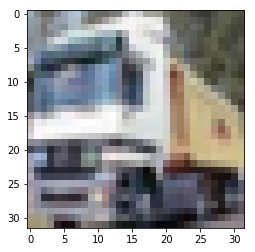

In [8]:
train_set_X,train_set_Y,test_set_X,test_set_Y,classes = Load_Data()
train_set_X = train_set_X.reshape(train_set_X.shape[0],3,32,32)
train_set_X = np.moveaxis(train_set_X,1,3)
print(train_set_X.shape)
train_set_Y =train_set_Y.reshape(1,train_set_Y.shape[0])
i = 1
plt.imshow(train_set_X[i])
print('y = '+str(train_set_Y[0,i])+'. It is a '+classes[train_set_Y[0,i]].decode('utf-8')+' picture')

In [0]:
def Initialize_Parameters(layers_dims,filter_conv,channels):
  
  parameters={}
  L = len(layers_dims)
  for l in range(1,L):
    WF = np.random.randn(layers_dims[l],layers_dims[l-1])*np.sqrt(1/layers_dims[l-1])*np.sqrt(1/layers_dims[l-1])
    bF = np.zeros((layers_dims[l],1))
    YF = np.random.randn(layers_dims[l],1)*np.sqrt(1/layers_dims[l-1])*np.sqrt(1/layers_dims[l-1])
    BF = np.zeros((layers_dims[l],1))
    
    parameters['WF'+str(l)] = WF 
    parameters['bF'+str(l)] = bF
    parameters['YF'+str(l)] = YF
    parameters['BF'+str(l)] = BF
  
  L = len(channels)
  for l in range(1,L):
    WC = np.random.randn(channels[l],filter_conv[l-1][0],filter_conv[l-1][1],channels[l-1])*np.sqrt(1/channels[l-1])
    bC = np.zeros((channels[l],1,1,1))
    
    parameters['WC'+str(l)] = WC
    parameters['bC'+str(l)] = bC
  
  return parameters

In [0]:
def Initialize_Optimizer(layers_dims,parameters,filter_conv,channels):
  
  v = {} 
  s = {}
  L = len(layers_dims)
  
  for l in range(1,L):
    dWF = np.zeros(parameters['WF'+str(l)].shape)
    dbF = np.zeros(parameters['bF'+str(l)].shape)
    dYF = np.zeros(parameters['YF'+str(l)].shape)
    dBF = np.zeros(parameters['BF'+str(l)].shape)

    s['dWF'+str(l)] = v['dWF'+str(l)] = dWF
    s['dbF'+str(l)] = v['dbF'+str(l)] = dbF
    s['dYF'+str(l)] = v['dYF'+str(l)] = dYF
    s['dBF'+str(l)] = v['dBF'+str(l)] = dBF
    
  L=len(channels)
  
  for l in range(1,L):
    dWC = np.zeros((channels[l],filter_conv[l-1][0],filter_conv[l-1][1],channels[l-1]))
    dbC = np.zeros((channels[l],1,1,1))
    
    s['dWC'+str(l)] = v['dWC'+str(l)] = dWC
    s['dbC'+str(l)] = v['dbC'+str(l)] = dbC
  
  return v,s

In [0]:
def sigmoid(Z):
  
  A = 1/(1+np.exp(-Z))
  return A

In [0]:
def relu(Z):
  
  A = np.maximum(Z,0.0001)
  return A

In [0]:
def softmax(Z):
  
  exp = np.exp(Z)
  expnorm = np.sum(exp,axis=0,keepdims=True)
  A = exp/expnorm
  assert(expnorm.shape == (1,exp.shape[1]))
  
  return A

In [0]:
def Compute_Z(A,W,b):
  
  Z = np.dot(W,A) + b
  return Z

In [0]:
def Forward_Propagation_Helper(A,W,b,Y,B,activation):
  
  m_train = A.shape[1]
  Z = Compute_Z(A,W,b)
  mu = np.sum(Z,axis=1,keepdims=True)/m_train
  Z_minus_mu = Z - mu
  sigma = np.sqrt(np.sum(np.square(Z_minus_mu),axis=1,keepdims=True)/m_train)
  ZNorm = Z_minus_mu/sigma
  Zcap = Y*ZNorm + B
  
  if(activation == 'relu'):
    A = relu(Zcap)
  elif(activation == 'sigmoid'):
    A = sigmoid(Zcap)
  elif(activation == 'softmax'):
    A = softmax(Zcap)
   
  return A,ZNorm,sigma

In [0]:
def Zero_Pad(A,p):
  
  A_pad = np.pad(A,((0,0),(p[0],p[0]),(p[1],p[1]),(0,0)),'constant',constant_values=(0,0))
  return A_pad

In [0]:
def Compute_Conv_Z(A_prev_slice,W,b):
  
  Z = np.sum(A_prev_slice*W) + b
  return Z

In [0]:
def Conv_Forward_Helper(A_prev,W,b,f,s,p,activation):
  
  (m,nH_prev,nW_prev,nC_prev) = A_prev.shape
  nH = int((nH_prev+2*p[0]-f[0])/s[0])+1
  nW = int((nW_prev+2*p[1]-f[1])/s[1])+1
  nC = W.shape[0]
  
  #print(m,nH_prev,nW_prev,nC_prev)
  Z = np.zeros((m,nH,nW,nC))
  A_prev = Zero_Pad(A_prev,p)
  
  for i in range(m):
    for h in range(nH):
      for w in range(nW):
        
        vert_start = h*s[0]
        vert_end = vert_start + f[0]
        horiz_start = w*s[1]
        horiz_end = horiz_start + f[1]
        
        A_prev_slice = A_prev[i,vert_start:vert_end,horiz_start:horiz_end,:]
        
        for c in range(nC):
          Z[i,h,w,c] = Compute_Conv_Z(A_prev_slice,W[c,:,:,:],b[c,:,:,:])
  
  if(activation == 'relu'):
    A = relu(Z)
  else:
    A = sigmoid(Z)
    
  return A

In [0]:
def Pool_Forward_Helper(A_prev,f,s,pooltype):
  
  (m,nH_prev,nW_prev,nC_prev) = A_prev.shape
  nH = int((nH_prev-f[0])/s[0])+1
  nW = int((nW_prev-f[1])/s[1])+1
  nC = nC_prev
  
  A = np.zeros((m,nH,nW,nC))
  
  for i in range(m):
    for h in range(nH):
      for w in range(nW):
        for c in range(nC):
          
          vert_start = h*s[0]
          vert_end = vert_start + f[0]
          horiz_start = w*s[1]
          horiz_end = horiz_start + f[1]
          
          A_prev_slice = A_prev[i,vert_start:vert_end,horiz_start:horiz_end,c]
      
          if(pooltype == 'max'):
            A[i,w,h,c] = np.max(A_prev_slice)
          else:
            A[i,w,h,c] = np.average(A_prev_slice)
  
  return A

In [0]:
def Forward_Propagation(train_set_X,parameters,keep_prob,layers_dims,filter_conv,filter_pool,stride_conv,stride_pool,padding):
  
  A = train_set_X
  L = len(filter_conv)
  activation = 'relu'
  pooltype = 'max'
  cache_C = {}
  
  for l in range(L):
    cache_C['A'+str(l)] = A
    A = Conv_Forward_Helper(A,parameters['WC'+str(l+1)],parameters['bC'+str(l+1)],filter_conv[l],stride_conv[l],padding[l],activation)
    if(l == L-1):
      cache_C['A'+str(L)] = A
    if(l % 2 == 1):
      cache_C['A_pool'+str(l)] = A
      A = Pool_Forward_Helper(A,filter_pool[int(l/2)],stride_pool[int(l/2)],pooltype) 
      if(l == L-1):
        cache_C['A_pool'+str(L)] = A
  
  L = len(layers_dims)-1
  A = A.reshape((A.shape[0],A.shape[1]*A.shape[2]*A.shape[3])).T
  cache_FC = {}
  
  for l in range(L):
    t = l+1
    cache_FC['A'+str(l)] = A
    if(t < L):
      activation = 'relu'
    elif(parameters['WF'+str(L)].shape[0] > 1):
      activation = 'softmax'
    else :
      activation = 'sigmoid'
    A,ZNorm,sigma = Forward_Propagation_Helper(A,parameters['WF'+str(t)],parameters['bF'+str(t)],parameters['YF'+str(t)],parameters['BF'+str(t)],activation)
    if (t != L):
      P = np.random.randn(A.shape[0],A.shape[1])
      P = 1-np.ceil(P-keep_prob[l])
      A = A*P
      A = A/keep_prob[l]
      cache_FC['P'+str(t)] = P
    cache_FC['ZNorm'+str(t)] = ZNorm
    cache_FC['sigma'+str(t)] = sigma
  cache_FC['A'+str(L)] = A
  
  return cache_C,cache_FC,A

In [0]:
def compute_cost_sigmoid(Y,A,parameters,regu,lambd,layers_dims):
  
  m_train = Y.shape[1]
  cost = np.nansum(Y*np.log(A))+np.sum((1-Y)*np.log(1-A))
  cost = -cost
  
  if(regu):
    L = len(layers_dims)
    sum = 0
    for l in range(1,L):
      WF = parameters['WF'+str(l)]
      sum = sum + np.sum(np.square(WF))
    sum = sum * (lambd*0.5/m_train)
    cost = cost + sum
  
  return cost

In [0]:
def compute_cost_softmax(Y,A,parameters,regu,lambd,layers_dims):
  
  m_train = Y.shape[1]
  cost = np.sum(Y*np.log(A))
  cost = -cost
  
  if(regu):
    L = len(layers_dims)
    sum = 0
    for l in range(1,L):
      WF = parameters['WF'+str(l)]
      sum = sum + np.sum(np.square(WF))
    sum = sum * (lambd*0.5/m_train)
    cost = cost + sum
   
  return cost

In [0]:
def relu_backward(dA,A):
  
  dZ = dA * np.int32(A>0)
  return dZ

In [0]:
def sigmoid_backward(dA,A):
  
  dZ = A*(1-A) * dA
  return dZ

In [0]:
def Backward_Propagation_Helper(flag,dA,W,Y,A_prev,A_curr,ZNorm,sigma,activation,regu,lambd):
  
  if(flag):
    dZcap = dA
  else:
    if(activation == 'relu'):
      dZcap = relu_backward(dA,A_curr)
    elif(activation == 'sigmoid'):
      dZcap = sigmoid_backward(dA,A_curr)
  
  m_train = A_curr.shape[1]
  dZNorm = Y * dZcap
  dZ = dZNorm / sigma
  dW = np.dot(dZ,A_prev.T)/m_train
  if(regu):
    dW = dW + W*lambd/m_train
  db = np.sum(dZ,axis=1,keepdims=True)/m_train
  dY = np.sum(dZcap * ZNorm,axis=1,keepdims=True)/m_train
  dB = np.sum(dZcap,axis=1,keepdims=True)/m_train
  dA = np.dot(W.T,dZ)
  
  assert(W.shape == dW.shape)
  
  return dA,dW,db,dY,dB

In [0]:
def Pool_Backward_Helper(dA,A_prev,f,s,pooltype):
  
  (m,nH_prev,nW_prev,nC_prev) = A_prev.shape
  (m,nH,nW,nC) = dA.shape
 
  #print(A_prev.shape)
  dA_prev = np.zeros(A_prev.shape)
  
  for i in range(m):
    for h in range(nH):
      for w in range(nW):
        for c in range(nC):
          
          vert_start = h*s[0]
          vert_end = vert_start + f[0]
          horiz_start = w*s[1]
          horiz_end = horiz_start + f[1]
          
          A_prev_slice = A_prev[i,vert_start:vert_end,horiz_start:horiz_end,c]
          
          if(pooltype == 'max'):
            mask = A_prev_slice == np.max(A_prev_slice)
            dA_prev[i,vert_start:vert_end,horiz_start:horiz_end,c] += mask*dA[i,h,w,c]
          elif(pooltype == 'average'):
            mask = np.ones((f[0],f[1]))
            dA_prev[i,vert_start:vert_end,horiz_start:horiz_end,c] += mask*dA[i,h,w,c]
  
  
  return dA_prev

In [0]:
def Conv_Backward_Helper(dA,W,A_prev,A_curr,activation,f,s,p):
  
  if(activation == 'relu'):
    dZ = relu_backward(dA,A_curr)
  else:
    dZ = sigmoid_backward(dA,A_curr)
   
  (m,nH_prev,nW_prev,nC_prev) = A_prev.shape
  (m,nH,nW,nC) = dZ.shape
  
  dA = np.zeros(A_prev.shape)
  dWC = np.zeros((nC,f[0],f[1],nC_prev))
  dbC = np.zeros((nC,1,1,1))
  
  A_prev = Zero_Pad(A_prev,p)
  dA = Zero_Pad(dA,p)
  #print(dA.shape,A_prev.shape,p)
  
  for i in range(m):
    for h in range(nH):
      for w in range(nW):
        
        vert_start = h*s[0]
        vert_end = vert_start + f[0]
        horiz_start = w*s[1]
        horiz_end = horiz_start + f[1]
        
        A_prev_slice = A_prev[i,vert_start:vert_end,horiz_start:horiz_end,:]
        
        for c in range(nC):
          dA[i,vert_start:vert_end,horiz_start:horiz_end,:] += dZ[i,h,w,c]*W[c,:,:,:]
          dWC[c,:,:,:] += A_prev_slice*dZ[i,h,w,c]
          dbC[c,:,:,:] += dZ[i,h,w,c]
  
  if(p[0]!=0 and p[1]!=0):
    dA = dA[:,p[0]:-p[0],p[1]:-p[1],:]
  
  assert(dA.shape == (m,nH_prev,nW_prev,nC_prev))
  
  return dA,dWC,dbC

In [0]:
def Backward_Propagation(train_set_Y,A,parameters,cache_FC,cache_C,keep_prob,regu,lambd,filter_conv,filter_pool,stride_conv,stride_pool,padding,layers_dims):
  
  grads = {}
  L = len(layers_dims)-1
  activation = 'relu'
  pooltype = 'max'
  
  dA = A - train_set_Y
  for l in reversed(range(L)):
    if(l == L-1):
      flag = True
    else:
      flag = False
      dA = dA * cache_FC['P'+str(l+1)]
      dA = dA/keep_prob[l]

    dA,dWF,dbF,dYF,dBF = Backward_Propagation_Helper(flag,dA,parameters['WF'+str(l+1)],parameters['YF'+str(l+1)],cache_FC['A'+str(l)],cache_FC['A'+str(l+1)],cache_FC['ZNorm'+str(l+1)],cache_FC['sigma'+str(l+1)],activation,regu,lambd)
    grads['dWF'+str(l+1)] = dWF
    grads['dbF'+str(l+1)] = dbF
    grads['dYF'+str(l+1)] = dYF
    grads['dBF'+str(l+1)] = dBF
  
  L = len(filter_conv)
  dA = dA.T
  shape = cache_C['A_pool'+str(L)].shape
  dA = dA.reshape(dA.shape[0],shape[3],shape[1],shape[2])
  dA = np.moveaxis(dA,1,3)
  
  for l in reversed(range(L)):
    if(l % 2 == 1):
      dA = Pool_Backward_Helper(dA,cache_C['A_pool'+str(l)],filter_pool[int(l/2)],stride_pool[int(l/2)],pooltype)
    dA,dWC,dbC = Conv_Backward_Helper(dA,parameters['WC'+str(l+1)],cache_C['A'+str(l)],cache_C['A'+str(l+1)],activation,filter_conv[l],stride_conv[l],padding[l])
    grads['dWC'+str(l+1)] = dWC
    grads['dbC'+str(l+1)] = dbC
    
  return grads

In [0]:
def Update_Parameters(grads,parameters,learning_rate,v,s,beta1,beta2,t,layers_dims,channels,epsilon=1e-8):

  L = len(layers_dims)
  
  for l in range(1,L):
    v['dWF'+str(l)] = beta1*v['dWF'+str(l)] + (1-beta1)*grads['dWF'+str(l)]
    vdWF_corr = v['dWF'+str(l)]/(1-(beta1**t))
    v['dbF'+str(l)] = beta1*v['dbF'+str(l)] + (1-beta1)*grads['dbF'+str(l)] 
    vdbF_corr = v['dbF'+str(l)]/(1-(beta1**t))
    v['dYF'+str(l)] = beta1*v['dYF'+str(l)] + (1-beta1)*grads['dYF'+str(l)]
    vdYF_corr = v['dYF'+str(l)]/(1-(beta1**t))
    v['dBF'+str(l)] = beta1*v['dBF'+str(l)] + (1-beta1)*grads['dBF'+str(l)]
    vdBF_corr = v['dBF'+str(l)]/(1-(beta1**t))

    s['dWF'+str(l)] = beta2*s['dWF'+str(l)] + (1-beta2)*(grads['dWF'+str(l)]**2)
    sdWF_corr = s['dWF'+str(l)]/(1-(beta2**t))
    s['dbF'+str(l)] = beta2*s['dbF'+str(l)] + (1-beta2)*(grads['dbF'+str(l)]**2)
    sdbF_corr = s['dbF'+str(l)]/(1-(beta2**t))
    s['dYF'+str(l)] = beta2*s['dYF'+str(l)] + (1-beta2)*(grads['dYF'+str(l)]**2)
    sdYF_corr = s['dYF'+str(l)]/(1-(beta2**t))
    s['dBF'+str(l)] = beta2*s['dBF'+str(l)] + (1-beta2)*(grads['dBF'+str(l)]**2)
    sdBF_corr = s['dBF'+str(l)]/(1-(beta2**t))
    
    parameters['WF'+str(l)] = parameters['WF'+str(l)] - learning_rate*vdWF_corr/(np.sqrt(sdWF_corr)+epsilon)
    parameters['bF'+str(l)] = parameters['bF'+str(l)] - learning_rate*vdbF_corr/(np.sqrt(sdbF_corr)+epsilon)
    parameters['YF'+str(l)] = parameters['YF'+str(l)] - learning_rate*vdYF_corr/(np.sqrt(sdYF_corr)+epsilon)
    parameters['BF'+str(l)] = parameters['BF'+str(l)] - learning_rate*vdBF_corr/(np.sqrt(sdBF_corr)+epsilon)

  L = len(channels)
  
  for l in range(1,L):
    v['dWC'+str(l)] = beta1*v['dWC'+str(l)] + (1-beta1)*grads['dWC'+str(l)]
    vdWC_corr = v['dWC'+str(l)]/(1-(beta1**t))
    v['dbC'+str(l)] = beta1*v['dbC'+str(l)] + (1-beta1)*grads['dbC'+str(l)]
    vdbC_corr = v['dbC'+str(l)]/(1-(beta1)**t)
    
    s['dWC'+str(l)] = beta2*s['dWC'+str(l)] + (1-beta2)*(grads['dWC'+str(l)]**2)
    sdWC_corr = s['dWC'+str(l)]/(1-(beta2**t))
    s['dbC'+str(l)] = beta2*s['dbC'+str(l)] + (1-beta2)*(grads['dbC'+str(l)]**2)
    sdbC_corr = s['dbC'+str(l)]/(1-(beta2**t))
    
    parameters['WC'+str(l)] -= learning_rate*vdWC_corr/(np.sqrt(sdWC_corr)+epsilon)
    parameters['bC'+str(l)] -= learning_rate*vdbC_corr/(np.sqrt(sdbC_corr)+epsilon)
  
  return parameters,v,s

In [0]:
def Shuffle_And_Split(train_set_X,train_set_Y,mini_batch_size):
  
  m_train = train_set_X.shape[0]
  perm = list(np.random.permutation(m_train))
  train_set_X = train_set_X[perm,:,:,:]
  train_set_Y = train_set_Y[:,perm]
  
  n = int(m_train/mini_batch_size)
  minibatches = []
  
  for i in range(n):
    X = train_set_X[i*mini_batch_size:(i+1)*mini_batch_size,:,:,:]
    Y = train_set_Y[:,i*mini_batch_size:(i+1)*mini_batch_size]
    minibatch = (X,Y)
    minibatches.append(minibatch)
  
  if(m_train % mini_batch_size != 0):
    X = train_set_X[n*mini_batch_size:m_train,:,:,:]
    Y = train_set_Y[:,n*mini_batch_size:m_train]
    minibatch = (X,Y)
    minibatches.append(minibatch)
  
  return minibatches

In [0]:
def Predict(X,parameters,keep_prob,layers_dims,filter_conv,filter_pool,stride_conv,stride_pool,padding):
  
  cache_C,cache_FC,A = Forward_Propagation(X,parameters,keep_prob,layers_dims,filter_conv,filter_pool,stride_conv,stride_pool,padding)
  L = len(layers_dims)-1
  
  if(parameters['WF'+str(L)].shape[0] == 1):
    A = np.abs(np.ceil(A-0.5))
    A = A.astype('int32')
  else:
    A = np.argmax(A,axis=0)
    A = np.eye(10)[A][0].T
   
  return A

In [0]:
def Model(train_set_X,train_set_Y,test_set_X,test_set_Y,learning_rate,epochs,layers_dims,keep_prob,channels,filter_conv,filter_pool,stride_conv,stride_pool,padding):
  
  beta1 = 0.8
  beta2 = 0.9
  beta3 = 0.99
  lambd = 0.7
  regu = False
  mini_batch_size = 25
  
  L = len(layers_dims)
  if(layers_dims[L-1] > 1):
    train_set_Y = np.eye(10)[train_set_Y][0].T
    test_set_Y = np.eye(10)[test_set_Y][0].T
    
  total_cost = []
  parameters = Initialize_Parameters(layers_dims,filter_conv,channels)
  v,s = Initialize_Optimizer(layers_dims,parameters,filter_conv,channels)
  
  for i in range(epochs):
    minibatches = Shuffle_And_Split(train_set_X,train_set_Y,mini_batch_size)
    for minibatch in minibatches:
      (X,Y) = minibatch
      cache_C,cache_FC,A = Forward_Propagation(X,parameters,keep_prob,layers_dims,filter_conv,filter_pool,stride_conv,stride_pool,padding)
      
      if(parameters['WF'+str(L-1)].shape[0] > 1):
        cost = compute_cost_softmax(Y,A,parameters,regu,lambd,layers_dims)
      else :
        cost = compute_cost_sigmoid(Y,A,parameters,regu,lambd,layers_dims)
      
      grads = Backward_Propagation(Y,A,parameters,cache_FC,cache_C,keep_prob,regu,lambd,filter_conv,filter_pool,stride_conv,stride_pool,padding,layers_dims)
      
      #if (i % 10000 == 0):
        #flag=Gradient_Checking(grads,parameters,X,Y,keep_prob=[1,1,1],regu=regu,lambd=lambd)
        #print("Result of Gradient Checking : "+str(flag))
        
      parameters,v,s = Update_Parameters(grads,parameters,learning_rate,v,s,beta2,beta3,i+1,layers_dims,channels)
      
      if(True):
        print('Cost after '+str(i)+'th Iteration : '+str(cost))
      
    if(i % 500 == 0):
        total_cost.append(cost)
     
  A_train = Predict(train_set_X,parameters,keep_prob,layers_dims,filter_conv,filter_pool,stride_conv,stride_pool,padding)
  A_test = Predict(test_set_X,parameters,keep_prob,layers_dims,filter_conv,filter_pool,stride_conv,stride_pool,padding)
  
  if(parameters['WF'+str(L-1)].shape[0] == 1):
    train_acc = 100-np.mean(np.abs(train_set_Y-A_train))*100
    test_acc = 100-np.mean(np.abs(test_set_Y-A_test))*100
    
  elif(parameters['WF'+str(L-1)].shape[0] > 1):
    train_temp = np.equal(np.argmax(A_train,axis=0),np.argmax(train_set_Y,axis=0))
    train_acc = np.mean(train_temp.astype('int32'))*100
    test_temp = np.equal(np.argmax(A_test,axis=0),np.argmax(test_set_Y,axis=0))
    test_acc = np.mean(test_temp.astype('int32'))*100
  
  print("Training Set Accuracy : "+str(train_acc))
  print("Test Set Accuracy : "+str(test_acc))
  
  plt.plot(total_cost)
  plt.xlabel('Iterations')
  plt.ylabel('Cost')
  plt.title("Learning_Rate : "+str(learning_rate))
  plt.show()  
  
  return parameters

In [0]:
def Calculate_HW(train_set_X,filter_conv,filter_pool,stride_conv,stride_pool,padding,channels):
  
  shape = train_set_X.shape
  h = shape[1]
  w = shape[2]
  L = len(filter_conv)
  
  for l in range(L):
    h = int((h+2*padding[l][0]-filter_conv[l][0])/stride_conv[l][0]) + 1
    w = int((w+2*padding[l][1]-filter_conv[l][0])/stride_conv[l][1]) + 1
    if(l%2 == 1):
      h = int((h-filter_pool[int(l/2)][0])/stride_pool[int(l/2)][0]) + 1
      w = int((w-filter_pool[int(l/2)][1])/stride_pool[int(l/2)][1]) + 1
  
  c = channels[L]
  
  return h*w*c

In [0]:
def Caller_Function():
  
  train_set_X,train_set_Y,test_set_X,test_set_Y = Data_Preprocessing()
  learning_rate = 0.3
  epochs = 5
  keep_prob = [1,1]
  channels = [train_set_X.shape[3]]
  channels.extend([32,64])
  filter_conv = [(3,3),(3,3)]
  filter_pool = [(2,2)]
  stride_conv = [(1,1),(1,1)]
  stride_pool = [(2,2)]
  padding = [(0,0),(0,0)]
  layers_dims = [Calculate_HW(train_set_X,filter_conv,filter_pool,stride_conv,stride_pool,padding,channels)]
  layers_dims.extend([1024,10])
  parameters = Model(train_set_X,train_set_Y,test_set_X,test_set_Y,learning_rate,epochs,layers_dims,keep_prob,channels,filter_conv,filter_pool,stride_conv,stride_pool,padding)
  
  for key,value in parameters.items():
    print(key,value)

In [0]:
Caller_Function()

Cost after 0th Iteration : 57.56111099455515
Cost after 0th Iteration : 61.56348552197319
Cost after 1th Iteration : 54.5281873320763
Cost after 1th Iteration : 55.536910240382205
Cost after 2th Iteration : 44.87751321845079
